In [1]:
# !pip install tensorflow==2.13.0

In [2]:
# import tensorflow as tf
# print(tf.__version__)

In [3]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from pathlib import Path
from shutil import copyfile
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-05-18 15:14:02.063553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747581242.570867      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747581242.701265      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
path_img='/kaggle/input/ethiopian-coffee-leaf-disease'
img_directory=os.listdir(path_img)
print("Class Skin Diseases:",img_directory)

Class Skin Diseases: ['ethiopian cofee leaf dataset']


Jumlah file dengan nama yang sama: 870


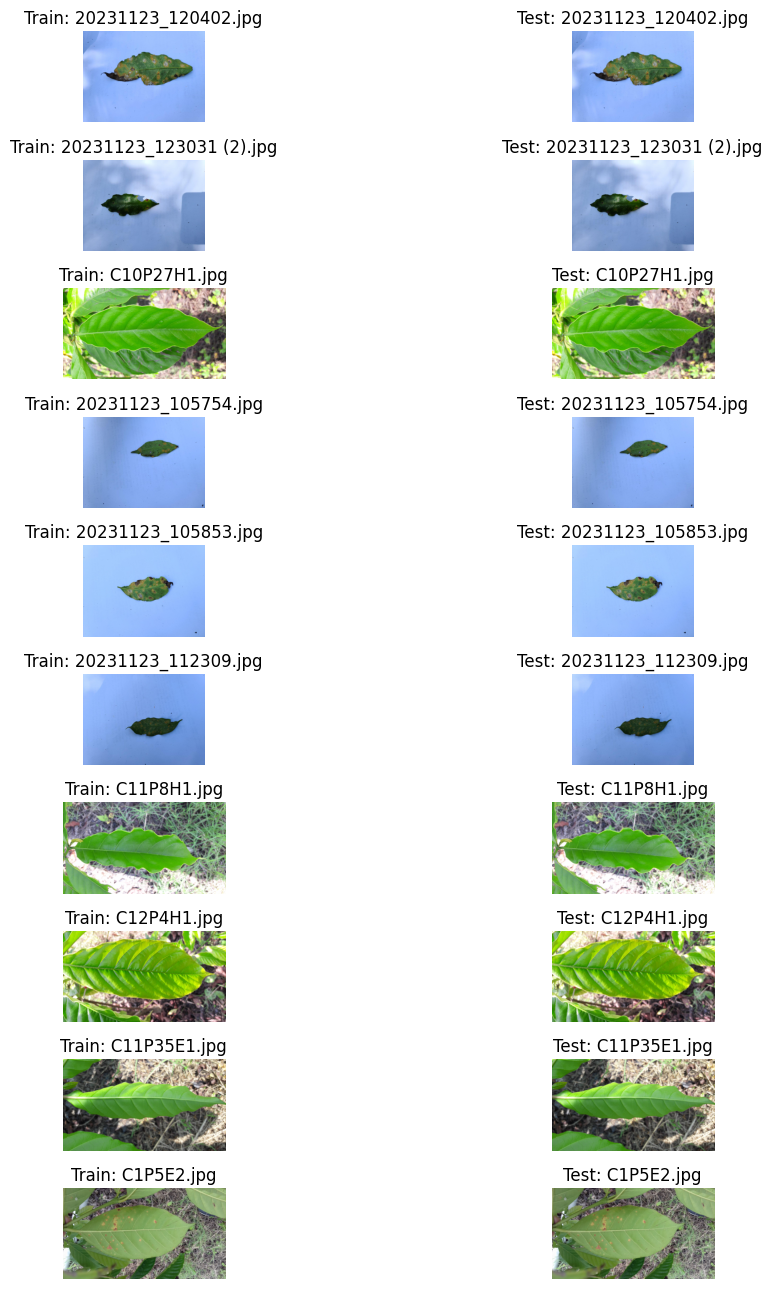

In [5]:
# Tes

def get_filepaths_by_name(root_dir):
    filepath_dict = {}
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            filepath_dict[file] = os.path.join(subdir, file)
    return filepath_dict

# Path ke folder train dan test
train_dir = "/kaggle/input/ethiopian-coffee-leaf-disease/ethiopian cofee leaf dataset/train aug"
test_dir = "/kaggle/input/ethiopian-coffee-leaf-disease/ethiopian cofee leaf dataset/test"

# Ambil dict nama file -> path
train_files = get_filepaths_by_name(train_dir)
test_files = get_filepaths_by_name(test_dir)

# Cari nama file yang sama
duplicate_filenames = list(set(train_files.keys()).intersection(set(test_files.keys())))
print(f"Jumlah file dengan nama yang sama: {len(duplicate_filenames)}")

# Ambil 10 file pertama
sample_names = duplicate_filenames[:10]

# Tampilkan gambar
fig, axs = plt.subplots(len(sample_names), 2, figsize=(13, 13))

for i, filename in enumerate(sample_names):
    train_img = Image.open(train_files[filename])
    test_img = Image.open(test_files[filename])

    axs[i, 0].imshow(train_img)
    axs[i, 0].set_title(f"Train: {filename}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(test_img)
    axs[i, 1].set_title(f"Test: {filename}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()



In [6]:
# Direktori awal untuk train dan test
train_dir = "/kaggle/input/ethiopian-coffee-leaf-disease/ethiopian cofee leaf dataset/train aug"
test_dir = "/kaggle/input/ethiopian-coffee-leaf-disease/ethiopian cofee leaf dataset/test"

# Direktori baru untuk dataset gabungan
combined_dir = "/kaggle/working/ethiopian cofee leaf dataset/dataset"

In [7]:
# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

In [8]:
# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

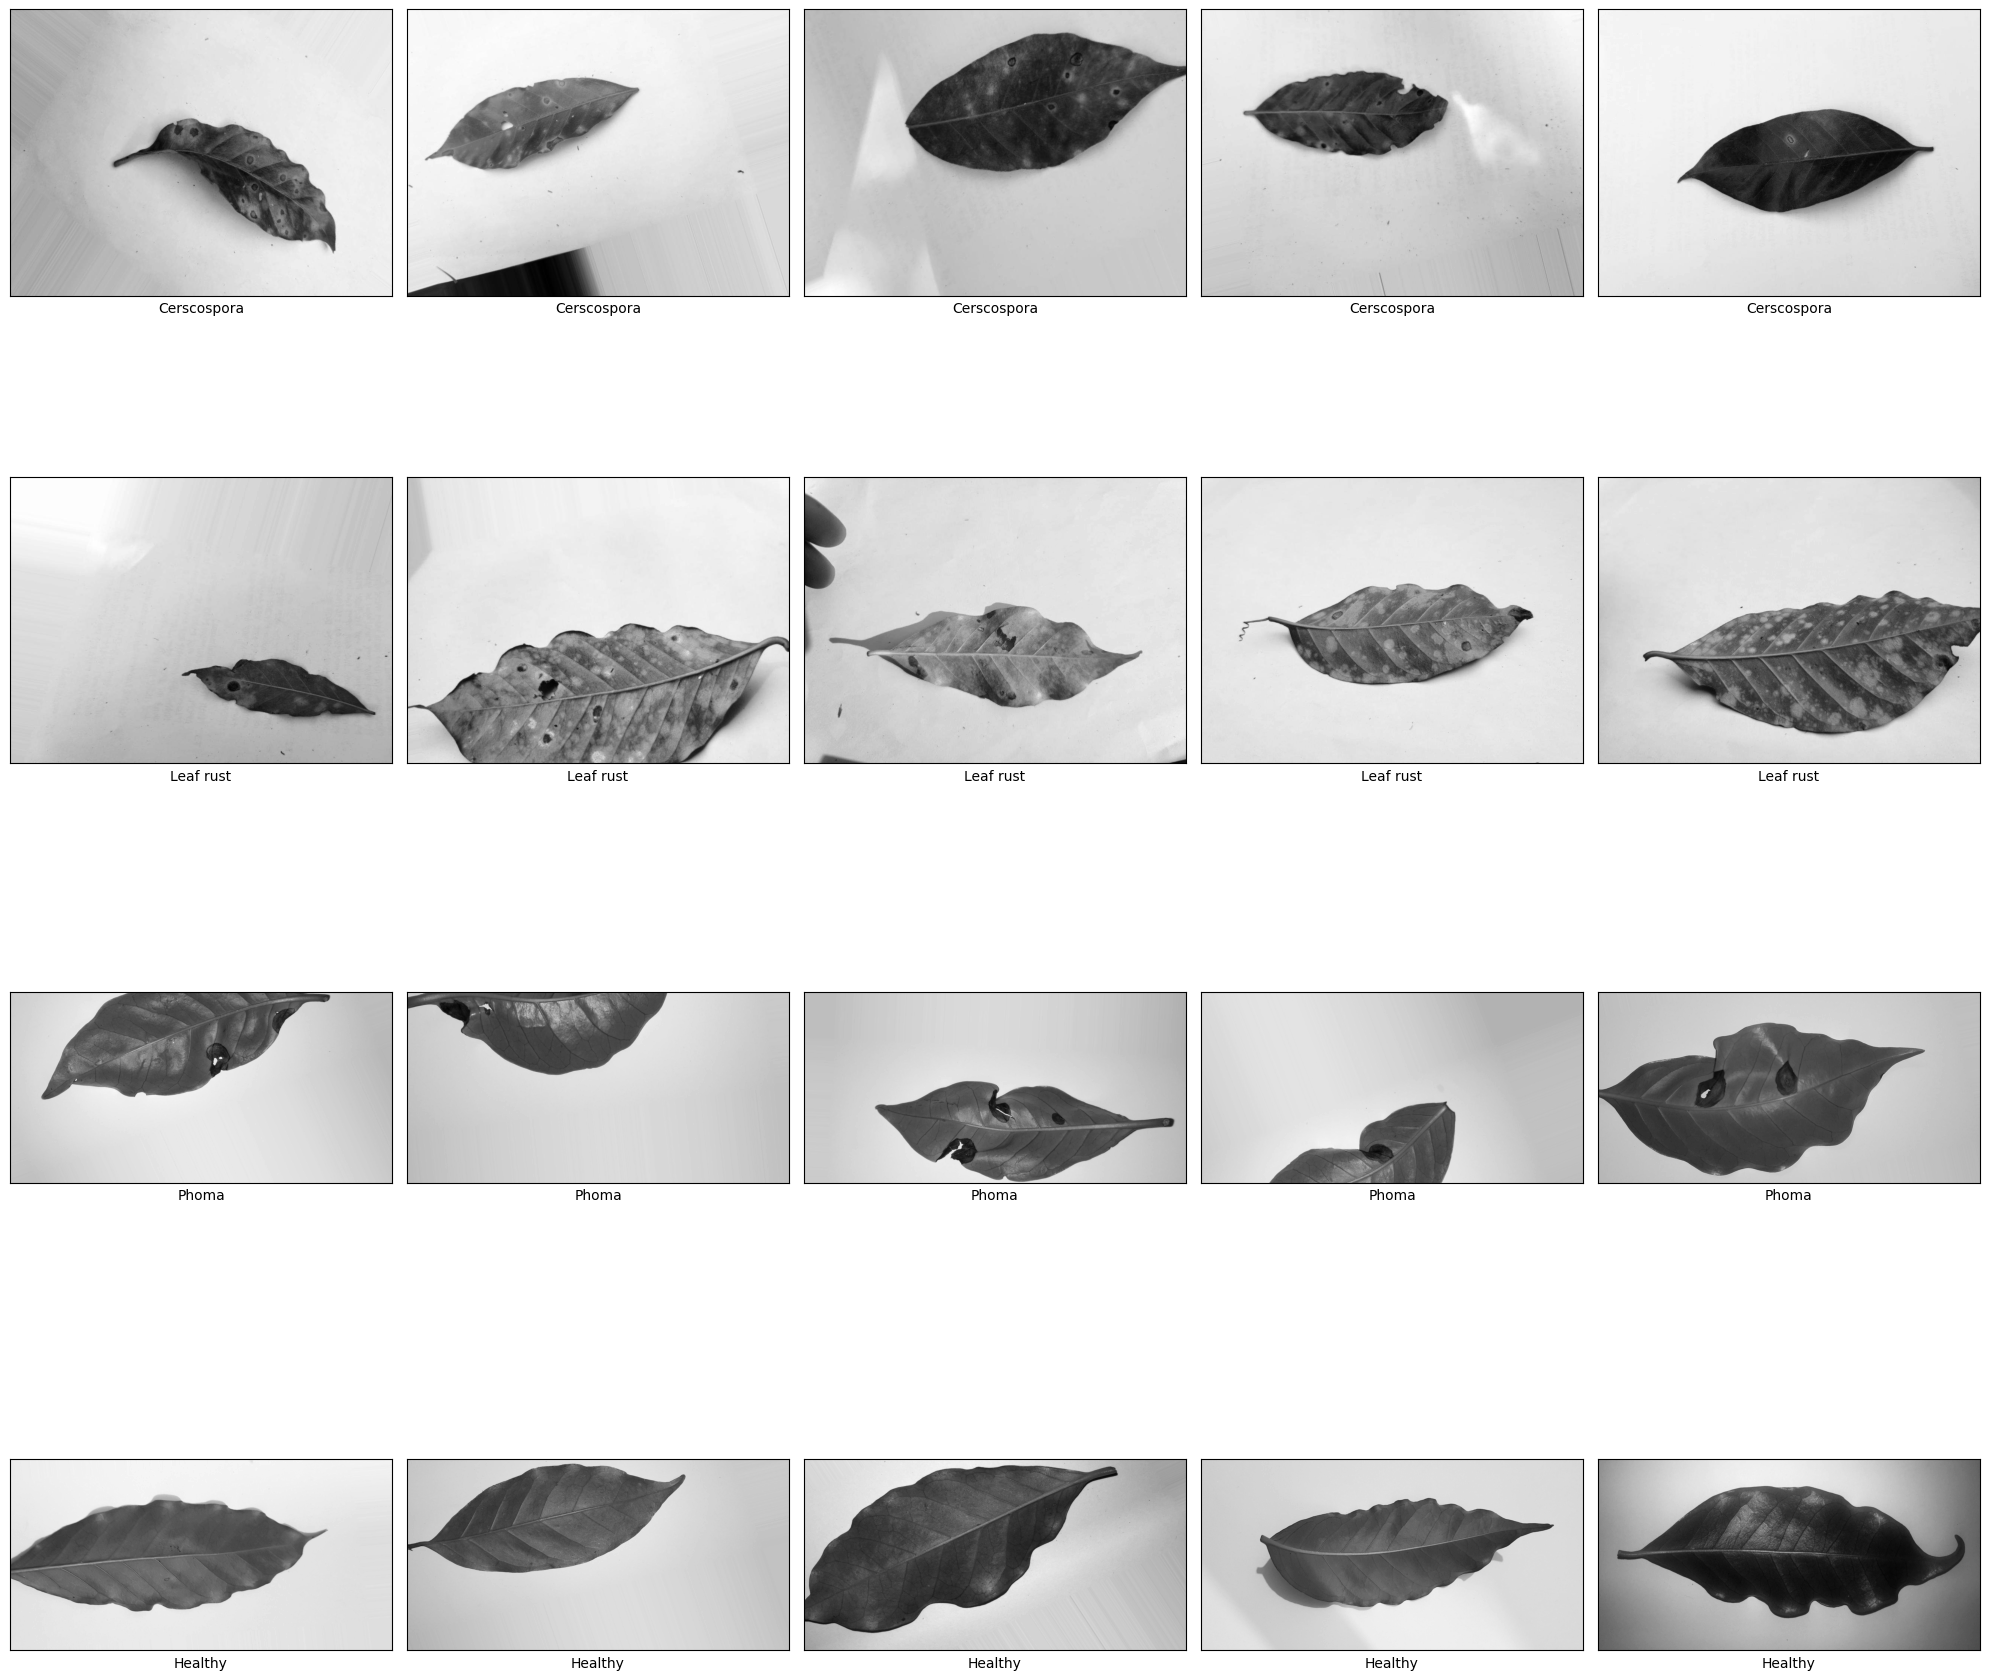

In [9]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
coffe_image = {}

# Tentukan path sumber train
path = "/kaggle/working/ethiopian cofee leaf dataset/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    coffe_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
path_sub = "/kaggle/working/ethiopian cofee leaf dataset/dataset/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(coffe_image.keys()), 5, figsize=(20, 20))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(coffe_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

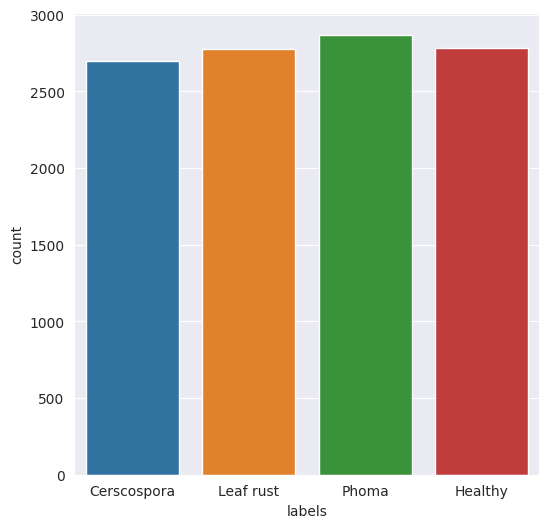

In [10]:
# Definisikan path sumber
coffe = "/kaggle/working/ethiopian cofee leaf dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(coffe):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(x=Label)

In [11]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath = coffe

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
Cerscospora    2700
Healthy        2782
Leaf rust      2778
Phoma          2870
dtype: int64

In [12]:
# Split df_resampled menjadi train dan test
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)

# Ubah label jadi string
train_df["labels"] = train_df["labels"].astype(str)
test_df["labels"] = test_df["labels"].astype(str)


In [13]:
# ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="path",
    y_col="labels",
    target_size=(124, 124),
    batch_size=32,
    color_mode='rgb',
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=42
)

# Validation generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="path",
    y_col="labels",
    target_size=(124, 124),
    batch_size=32,
    color_mode='rgb',
    class_mode="categorical",
    subset="validation",
    shuffle=False,
    seed=42
)

# Test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="labels",
    target_size=(124, 124),
    batch_size=1,
    color_mode='rgb',
    class_mode="categorical",
    shuffle=False
)

Found 7124 validated image filenames belonging to 4 classes.
Found 1780 validated image filenames belonging to 4 classes.
Found 2226 validated image filenames belonging to 4 classes.


In [14]:
model_1 = Sequential([
    Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(124, 124, 3)),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    # Hanya GlobalAveragePooling, tanpa Flatten
    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    Dropout(0.4),

    Dense(4, activation='softmax')  # 10 kelas
])

model_1.compile(
    optimizer=RMSprop(
        learning_rate=0.0006,     # default: 0.001 — bisa dikurangi jika model overfitting
        rho=0.9,                 # decay rate untuk moving average dari squared gradient
        momentum=0.0,            # bisa ditambah jika ingin mempercepat konvergensi
        epsilon=1e-07,           # kecilkan jika nilai loss sangat kecil atau tidak stabil
        centered=False           # True untuk memperhitungkan rata-rata gradien (lebih stabil, tapi lambat)
    ),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747581410.913141      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747581410.913882      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 124, 124, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 124, 124, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 62, 62, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 31, 31, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 31, 31, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,868 (128.39 KB)

 Trainable params: 32,644 (127.52 KB)

 Non-trainable params: 224 (896.00 B)

In [15]:
# Callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True, verbose=1)
]

In [16]:
# Fitting / training model
history_1 = model_1.fit(train_generator,
                        epochs=50,
                        batch_size=32,
                        validation_data=validation_generator,
                        callbacks=callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1747581416.403862      65 service.cc:148] XLA service 0x7ce29c047580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747581416.404985      65 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747581416.404995      65 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747581416.978711      65 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/223 ━━━━━━━━━━━━━━━━━━━━ 30:00 8s/step - accuracy: 0.1562 - loss: 2.0974

I0000 00:00:1747581421.650533      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 34/223 ━━━━━━━━━━━━━━━━━━━━ 1:02 333ms/step - accuracy: 0.5681 - loss: 1.0438

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.7019 - loss: 0.7211
Epoch 1: val_loss improved from inf to 1.06187, saving model to best_model.h5
223/223 ━━━━━━━━━━━━━━━━━━━━ 87s 354ms/step - accuracy: 0.7022 - loss: 0.7205 - val_accuracy: 0.4618 - val_loss: 1.0619
Epoch 2/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.8355 - loss: 0.4128
Epoch 2: val_loss improved from 1.06187 to 0.46332, saving model to best_model.h5
223/223 ━━━━━━━━━━━━━━━━━━━━ 74s 331ms/step - accuracy: 0.8355 - loss: 0.4127 - val_accuracy: 0.8022 - val_loss: 0.4633
Epoch 3/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.8604 - loss: 0.3571
Epoch 3: val_loss improved from 0.46332 to 0.37082, saving model to best_model.h5
223/223 ━━━━━━━━━━━━━━━━━━━━ 73s 325ms/step - accuracy: 0.8604 - loss: 0.3571 - val_accuracy: 0.8584 - val_loss: 0.3708
Epoch 4/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.8722 - loss: 0.3237
Epoch 4: val_loss improved from 0.37082 to 0.34265, savin

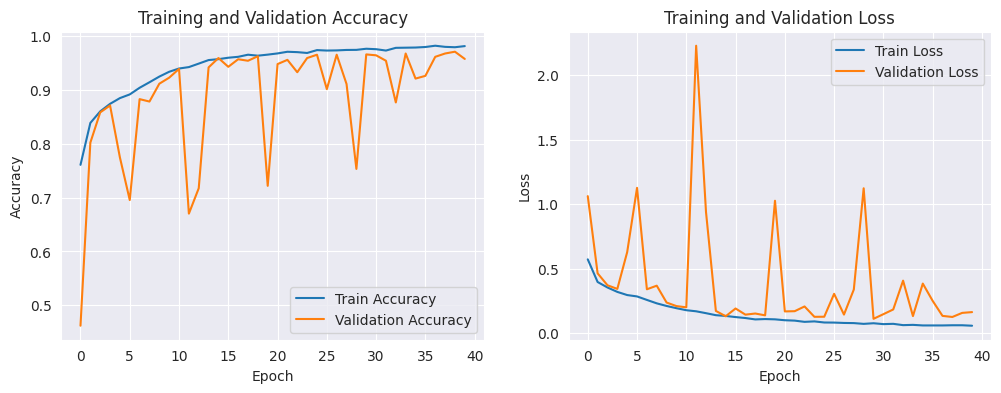

In [17]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'], label='Train Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'], label='Train Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [18]:
from sklearn.metrics import classification_report

def generate_classification_report(generator, model, set_name="Dataset"):
    # Reset generator
    generator.reset()

    # Predict
    pred_probs = model.predict(generator, verbose=0)
    y_pred = np.argmax(pred_probs, axis=1)
    y_true = generator.classes

    class_labels = list(generator.class_indices.keys())

    print(f"\n Classification Report for {set_name}:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

In [19]:
generate_classification_report(test_generator, model_1, "Test Set")


 Classification Report for Test Set:
              precision    recall  f1-score   support

 Cerscospora       0.95      0.98      0.97       540
     Healthy       0.97      0.97      0.97       556
   Leaf rust       0.96      0.92      0.94       556
       Phoma       0.99      0.99      0.99       574

    accuracy                           0.97      2226
   macro avg       0.97      0.97      0.97      2226
weighted avg       0.97      0.97      0.97      2226



In [20]:
cofee_dataset = "/kaggle/working/ethiopian cofee leaf dataset/dataset"

# Direktori penyimpanan TFLite dan label
TFLITE_DIR = Path("/kaggle/working/tflite")
TFLITE_DIR.mkdir(parents=True, exist_ok=True)

# 1. Konversi model ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
tflite_model = converter.convert()

# Simpan model tflite
tflite_model_path = TFLITE_DIR / "model.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"✅ Model TFLite disimpan di: {tflite_model_path}")

# 2. Ambil label dari nama subfolder dalam dataset
labels = sorted([
    label for label in os.listdir(cofee_dataset)
    if os.path.isdir(os.path.join(cofee_dataset, label))
])

# Simpan label ke file label.txt
label_file_path = TFLITE_DIR / "label.txt"
with open(label_file_path, "w") as f:
    for label in labels:
        f.write(label + "\n")

print(f"✅ Label disimpan di: {label_file_path}")
print("📄 Daftar label:")
for i, label in enumerate(labels):
    print(f"{i}. {label}")


Saved artifact at '/tmp/tmpnadqy8mc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 124, 124, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  137316717551760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137316717553488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137316717554640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137316717553104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137316717552912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137316717553680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137316717554256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137316717552720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137316717556368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137316717556176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13731671755521

W0000 00:00:1747584340.186431      19 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1747584340.186467      19 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1747584340.198150      19 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
